# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [50]:
# Imports here
import numpy as np                    # Import numpy library
import torch                          # Import pytorch

from torchvision import transforms   # Required to transform the data
from torchvision import datasets     # Required to load the datasets with ImageFolder

from torchvision import models       # Required to get the pre-Trained Model
from torch import nn                 # Required for classifier
from collections import OrderedDict  # Required for classifier

from torch import optim              #Required to optimize the paramaters while training the model
from torch.optim import lr_scheduler #Required to decay the Learning Rate while training the model
import time                          #Required to get the current time while training the model
import copy                          #Required to do the deep copy of model while training the model
from PIL import Image                #Required to open the image
import torch.nn.functional as F      #Required to use F.softmax function  
import matplotlib.pyplot as plt      #Required to plot the image in Sanity check
import seaborn as sns                #Required to plot the image in Sanity check

In [2]:
#Global constants and variables
#Create some constants so to reuse them. in C++/.Net we usually use uppercase for the constants
TRAIN = "train"
VALID = "valid"
TEST  = "test"

ARCH                   = "densenet121"
DROPOUT                = 0.5
TRAINEDMODEL_FEATURES  = 102 #we have 102 catagores of flower

LEARNING_RATE          = 0.001
STEP_SIZE              = 4
GAMMA                  = 0.1
numEpochs              = 12 # Number of epochs 
                            # One iteration is full run of feedforward and backpropagation through the network.

#Normalise mean and standard deviation is already provided
normMean = [0.485, 0.456, 0.406]
normStd  = [0.229, 0.224, 0.225]

isCuda = True
if (isCuda):
    device = "cuda:0"
else:
    device = "cpu"
    
#checkpoint path
CHECKPOINT_PATH = "VikasClassifier.pth"

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir  = 'flowers'

train_dir = data_dir + '/' + TRAIN
valid_dir = data_dir + '/' + VALID
test_dir  = data_dir + '/' + TEST

#Create dictonary to easily get the directories
dirs = {TRAIN: train_dir, VALID: valid_dir, TEST : test_dir}

print("Data Loaded")

Data Loaded


In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
#from torchvision import transforms #Required to transform the data
'''
Here we are doing robust transformations for Training data as images could be rotated/flipped/cropped
but doing simple transformation for validation and test data
'''
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(normMean, normStd)]),
    VALID: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normMean, normStd)]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normMean, normStd)]),
}

# TODO: Load the datasets with ImageFolder
#from torchvision import datasets #Required to load the datasets with ImageFolder
trainData = datasets.ImageFolder(train_dir, transform = data_transforms[TRAIN])
validData = datasets.ImageFolder(valid_dir, transform = data_transforms[VALID])
testData  = datasets.ImageFolder(test_dir , transform = data_transforms[TEST])

#Get the size of each datasets
print("Size of Training dataset   = ", len(trainData))
print("Size of Validation dataset = ", len(validData))
print("Size of Test dataset       = ", len(testData))

#Create dictionary for database sizes used in calaculating loss
datasetSizes = {TRAIN: len(trainData), VALID: len(validData), TEST : len(testData)}

# TODO: Using the image datasets and the trainforms, define the dataloaders
# Tried using different batch sizes for each datasets
trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 64, shuffle = True)
validLoader = torch.utils.data.DataLoader(validData, batch_size = 32, shuffle = True)
testLoader  = torch.utils.data.DataLoader(testData,  batch_size = 16, shuffle = True)

#Dataloaders dictionary
dataloaders = {TRAIN:trainLoader, VALID:validLoader, TEST:testLoader }

#Get class ids
class_idx = trainData.class_to_idx

print("Executed : Transforms for the training, validation, and testing sets")

Size of Training dataset   =  6552
Size of Validation dataset =  818
Size of Test dataset       =  819
Executed : Transforms for the training, validation, and testing sets


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
#Since machines works with numbers, we need to create a mapping from actual flower catagoreis to numbers between 1 and 102 
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print("Executed Cell4 : Label Mapping")

Executed Cell4 : Label Mapping


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [6]:
#Define function to get pretrained model based on arch
def GetPreTrainedModel():
    if ARCH   == 'vgg16':
        model = models.vgg16(pretrained=True)        
    elif ARCH == 'densenet121':
        model = models.densenet121(pretrained=True)
    elif ARCH == 'alexnet':
        model = models.alexnet(pretrained = True)
    else:
        print("{} is not a valid model.should be among 'vgg16/densenet121/alexnet'?".format(arch))
    return model, model.classifier.in_features

In [7]:
# TODO: Build and train your network
def CreateModel(class_to_idx):

    #from torchvision import models #Required to get the pre-Trained Model

    #Setp1 : Get the pre-Trained Model
    model, numInputFeaturesPrerainedModel = GetPreTrainedModel()
    
    #Step2 : Stop the model to update weights for pre-Trained Model
    for param in model.parameters():
        param.requires_grad = False

    #Step3 : check the architecture of pre-Trained Model so to see the classification    
    #print(model)
    print("pre-Trained Model in_features  : ", model.classifier.in_features)
    print("pre-Trained Model out_features : ", model.classifier.out_features)

    #from torch import nn # Required for classifier
    #from collections import OrderedDict  # Required for classifier

    # Update Model Classifier
    #lets have 3 hidden layers and use RELU activation function and softmax as final layer
    hiddenLayers=[int(numInputFeaturesPrerainedModel/2),int(numInputFeaturesPrerainedModel/4),int(numInputFeaturesPrerainedModel/8)]
    classifier = nn.Sequential(OrderedDict([
        ('dropout'          , nn.Dropout(DROPOUT)),
        ('inputs'           , nn.Linear(in_features=numInputFeaturesPrerainedModel,  out_features=hiddenLayers[0])),
        ('relu1'            , nn.ReLU()),
        ('hiddenLayer1'     , nn.Linear(hiddenLayers[0], hiddenLayers[1])),
        ('relu2'            , nn.ReLU()),
        ('hiddenLayer2'     , nn.Linear(hiddenLayers[1], hiddenLayers[2])),
        ('relu3'            , nn.ReLU()),
        ('lastHiddenLayer'  , nn.Linear(hiddenLayers[2],TRAINEDMODEL_FEATURES)),
        ('output'           , nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    print("Created Model in_features  : ", model.classifier.inputs.in_features)
    print("Created Model out_features : ", model.classifier.lastHiddenLayer.out_features)
    print("Created Model dropout      : ", model.classifier.dropout.p)
    
    model.class_to_idx = class_to_idx
    if (isCuda):
        model.cuda()
        
    return model

In [8]:
#Define function to train the Model
''' 
model      -> model to be trained
criterion  -> method used to evaluate the model fit.
optimizer  -> optimization technique used to update the weights.
scheduler  -> provides different methods for adjusting the learning rate and step size used during optimization.
'''
#import time #Required to get the current time
#import copy #Required to do the deep copy of model
def trainModel(model, criterion, optimizer, scheduler, dataloaders):    
    #Capture start time
    startTime = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(numEpochs):        
        print("Epoch: {:02}/{:02}...".format(epoch+1, numEpochs), end='') #end='' prevents next print statement in newline
        # Each epoch has a training and validation phase
        for phase in [TRAIN, VALID]:
            if phase == TRAIN:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:                
                inputs = inputs.to(device)
                labels = labels.to(device)
                model  = model.to(device)
                #print("Tensor Devices: ", inputs.device, labels.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects.double() / datasetSizes[phase]

            print("...{} [Loss: {:.4f}".format(phase, epoch_loss), "Accuracy: {:.4f}]".format(epoch_acc), end='')


            # deep copy the model
            if phase == VALID and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - startTime
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Train the network
#
model = CreateModel(trainData.class_to_idx)

# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
#from torch import optim #Required to optimize the paramaters while training the model
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

# Decay LR by a factor of 0.1 every 4 epochs
#from torch.optim import lr_scheduler #Required to decay the Learning Rate while training the model
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

TrainedModel = trainModel(model, criterion, optimizer,scheduler, dataloaders)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 109151123.23it/s]


pre-Trained Model in_features  :  1024
pre-Trained Model out_features :  1000
Created Model in_features  :  1024
Created Model out_features :  102
Created Model dropout      :  0.5
Epoch: 01/12......train [Loss: 4.1159 Accuracy: 0.1065]...valid [Loss: 2.8481 Accuracy: 0.2922]
Epoch: 02/12......train [Loss: 2.7761 Accuracy: 0.3130]...valid [Loss: 1.7025 Accuracy: 0.5513]
Epoch: 03/12......train [Loss: 2.1853 Accuracy: 0.4196]...valid [Loss: 1.2784 Accuracy: 0.6638]
Epoch: 04/12......train [Loss: 1.8832 Accuracy: 0.4928]...valid [Loss: 1.0353 Accuracy: 0.7213]
Epoch: 05/12......train [Loss: 1.6059 Accuracy: 0.5667]...valid [Loss: 0.8077 Accuracy: 0.7958]
Epoch: 06/12......train [Loss: 1.5419 Accuracy: 0.5846]...valid [Loss: 0.7689 Accuracy: 0.8032]
Epoch: 07/12......train [Loss: 1.5173 Accuracy: 0.5966]...valid [Loss: 0.7592 Accuracy: 0.7946]
Epoch: 08/12......train [Loss: 1.4680 Accuracy: 0.6018]...valid [Loss: 0.7366 Accuracy: 0.8105]
Epoch: 09/12......train [Loss: 1.4689 Accuracy: 0.5

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [10]:
#Define function to Test the model
def testModel(model):
    model.eval()
    model.to(device)
    correct = 0
    total   = 0
    
    with torch.no_grad(): #we are not interested to train with this dataset.
        for idx, (images, labels) in enumerate(dataloaders[TEST]):
            if isCuda:
                images, labels = images.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(images)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the accuracy
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('Test Accuracy of the network: %d %%' % (100 * correct / total))  
    print('Testing completed')

In [11]:
# TODO: Do validation on the test set
testModel(model)

Test Accuracy of the network: 87 %
Test Accuracy of the network: 84 %
Test Accuracy of the network: 87 %
Test Accuracy of the network: 85 %
Test Accuracy of the network: 85 %
Test Accuracy of the network: 84 %
Test Accuracy of the network: 83 %
Test Accuracy of the network: 82 %
Test Accuracy of the network: 83 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 82 %
Test Accuracy of the network: 82 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 82 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# TODO: Save the checkpoint 
model.class_to_idx = trainData.class_to_idx
model.cpu()
torch.save({'arch'          : ARCH,
            'state_dict'    : model.state_dict(),
            'inputFeatures' : model.classifier.inputs.in_features,
            'outputFeatures': model.classifier.lastHiddenLayer.out_features,
            'dropout'       : model.classifier.dropout.p,
            'class_to_idx'  : model.class_to_idx},
            CHECKPOINT_PATH)
print("Checkpoint '{}' Saved".format(CHECKPOINT_PATH))

Checkpoint 'VikasClassifier.pth' Saved


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def loadModel():
    print("loading Checkpoint '{}'".format(CHECKPOINT_PATH))
    checkpoint       = torch.load(CHECKPOINT_PATH)
    
    model, numInputFeaturesPrerainedModel = GetPreTrainedModel()
    inputFeatures    = checkpoint['inputFeatures']
    outputFeatures   = checkpoint['outputFeatures']
    dropout          = checkpoint['dropout']
    
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.class_to_idx = checkpoint['class_to_idx']
    hiddenLayers=[int(inputFeatures/2),int(inputFeatures/4),int(inputFeatures/8)]

    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
        ('dropout'       , nn.Dropout(dropout)),
        ('inputs'        , nn.Linear(in_features=inputFeatures,  out_features=hiddenLayers[0])),
        ('relu1'         , nn.ReLU()),
        ('hiddenLayer1'  , nn.Linear(hiddenLayers[0], hiddenLayers[1])),
        ('relu2'         , nn.ReLU()),
        ('hiddenLayer2'  , nn.Linear(hiddenLayers[1], hiddenLayers[2])),
        ('relu3'         , nn.ReLU()),
        ('lastHiddenLayer'  , nn.Linear(hiddenLayers[2],outputFeatures)),
        ('output'        , nn.LogSoftmax(dim=1))]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    print("Loaded Model in_features  : " , model.classifier.inputs.in_features)
    print("Loaded Model out_features : " , model.classifier.lastHiddenLayer.out_features)
    print("Loaded Model dropout      : " , model.classifier.dropout.p)
    
    return model

loadedModel = loadModel()
testModel(loadedModel)

loading Checkpoint 'VikasClassifier.pth'


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Loaded Model in_features  :  1024
Loaded Model out_features :  102
Loaded Model dropout      :  0.5
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 87 %
Test Accuracy of the network: 85 %
Test Accuracy of the network: 88 %
Test Accuracy of the network: 86 %
Test Accuracy of the network: 83 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 81 %
Test Accuracy of the network: 79 %
Test Accuracy of the network: 79 %
Test Accuracy of the network: 79 %
Test Accuracy of the network: 78 %
Test Accuracy of the network: 79 %
Test Accuracy of the network: 79 %
Test Accuracy of the network: 80 %
Test Accuracy of the network: 80 %
Test Accuracy of the network: 79 %
Test Accuracy of the network: 80 %
Test Accuracy of the network: 79 %
Test Accuracy of the network: 80 %
Test Accuracy of the netw

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # Open the image
    
    imgPil = Image.open(image)
    
    #do the adjustments
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(normMean, normStd)])
   
    return adjustments(imgPil)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [44]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean  = np.array(normMean)
    std   = np.array(normStd)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [24]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # Process image
    img = process_image(image_path)
    
    # Add batch of size 1 to image
    img_batch = img.unsqueeze(0)
    
    model_input = img_batch.float()
    
    # Probabilities using softmax
    with torch.no_grad():
        probs = torch.exp(model.forward(model_input))
    
    probability = F.softmax(probs.data,dim=1)
    
    return probability.topk(topk)

In [27]:
img = (data_dir + '/test/1/image_06743.jpg')
val1, val2 = predict(img, model)
print(val1)
print(val2)

tensor(1.00000e-02 *
       [[ 2.0962,  1.0173,  1.0048,  0.9856,  0.9824]])
tensor([[  0,  84,  49,  76,  50]])


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [60]:
# TODO: Display an image along with the top 5 classes
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[1]
    title_ = cat_to_name[flower_num]
    print(title_)
    # Plot flower
    image_path = data_dir + '/' + image_path 
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probabilities = predict(image_path, model)
    
    probs    = np.array(probabilities[0][0])
    flowers  = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0])]
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()


pink primrose


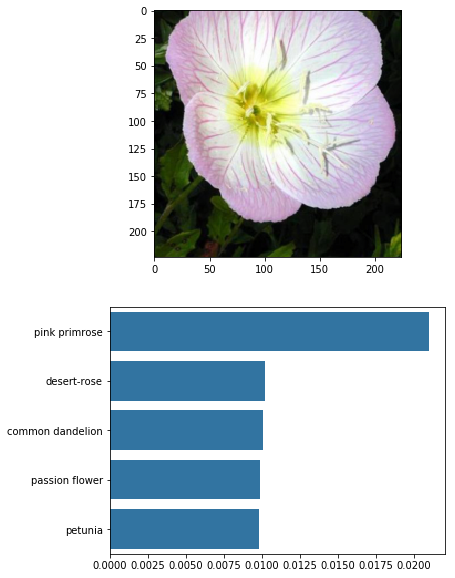

blackberry lily


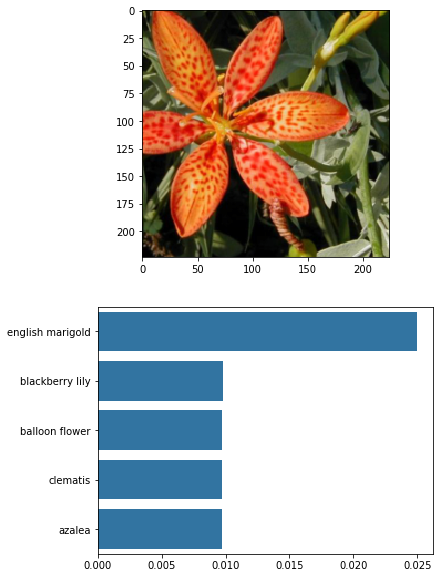

In [61]:
#Check Sanity
plot_solution('test/1/image_06743.jpg'  , model)  #first in the test folder
plot_solution('test/102/image_08042.jpg', model)  #last in the test folder